# Inference and Validation 

- model 1 : CE model on street view  
- model 2 : MSE model on street view

- 1. Visualize to compare two models output
- 2. Compare model confidence about the result 

In [1]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
import random
import matplotlib.pyplot as plt
from rich.console import Console

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#--- all infos
inference_dict ={
    'models':[],
    'cfgs':[],
    'predictions':[],
    'labels':[]
}

#--- argparser
cfgs_names = ['finetune_5.yaml', 'finetune_6.yaml']
for cfg_name in cfgs_names:    
    parser = argparse.ArgumentParser()
    parser.add_argument('--cfg', type=str, default=os.path.join('./configs', cfg_name))
    args = parser.parse_args(args=[])
    cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))
    inference_dict['cfgs'].append(cfg)
    print("Model run version : ", cfg.RUN_VERSION)

Model run version :  15
Model run version :  16


In [3]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = os.listdir(train_path)
names_train, names_valid = train_test_split(names_data, test_size=0.1, random_state=1)

In [4]:
for cfg in inference_dict['cfgs']:   
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )

    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)

    inference_dict['models'].append(model)
    print("#------------------------------------")
    print(" Model Name : ",cfg.MODEL)

/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


In [5]:
ckpt_paths = [
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/15_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.65_epoch_8.pth",
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/16_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_MSE_tensor_epoch_12.pth" ]

for i,model in enumerate(inference_dict['models']):
    model.load_state_dict(torch.load(ckpt_paths[i]))

In [6]:
train_set = map_dataset.Map_Dataset_v5(names_train,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid") 
valid_set = map_dataset.Map_Dataset_v5(names_valid,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid")  

In [7]:
print(train_set.__getitem__(0)[0].shape)
print(train_set.__getitem__(0)[1])

torch.Size([3, 448, 448])
0


idx :  3
0 < Label > 
2 < 3084 Model Prediction > 
tensor([[ 0.6020,  0.4268,  2.7216, -0.5758, -0.5290, -3.0649,  1.1163]],
       device='cuda:3', grad_fn=<AddmmBackward0>)
tensor([[0.0800, 0.0672, 0.6665, 0.0246, 0.0258, 0.0020, 0.1338]],
       device='cuda:3', grad_fn=<SoftmaxBackward0>)


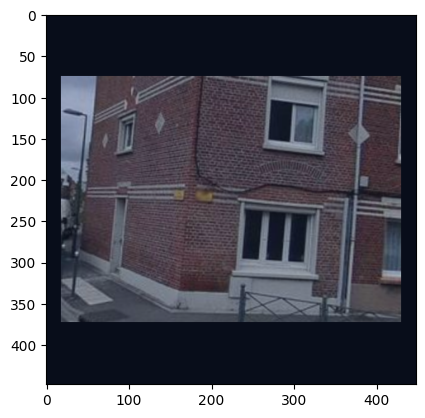

In [49]:
#--- Single image for Visualization 
# A model : Cross-entropy loss
# B model : MSE or MAE Loss 
#--- Test For Train Image
idx_ = random.randint(0,999)
idx_ = 3
print("idx : ", idx_)

dataset = valid_set
img_torch = dataset.__getitem__(idx_)[0]
#RS_utils.torch_display(img_torch, False, True)

#--- inference
device = "cuda:3"


def infer_model(img_torch,model,loss_type):
    
    img_torch = img_torch.to(device)
    
    model = model.eval()
    model = model.to(device)
    img_torch = img_torch.unsqueeze(0)
    preds = model(img_torch)
    
    if loss_type == "CE":
        preds_ = preds.argmax(-1)
    elif loss_type == "MSE" or loss_type == "MAE":
        preds_ = preds
    print(dataset.__getitem__(idx_)[1], "< Label > ")
    print(preds_.item(), f"< {i} Model Prediction > ")
    print(preds)
    print(preds.softmax(-1))
    
    img_torch = img_torch.squeeze(0)
    img = img_torch.clone() 
    
    # denormal
    img = ((img) * 0.22) + 0.5
    # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    #-----
            
    img = img.permute(1,2,0).cpu()
    img = np.asarray(img)   
    plt.imshow(img)
        
            
#-- 
infer_model(img_torch,inference_dict['models'][0],"CE")

In [51]:
aa = [ 0.6020,  0.4268,  2.7216, -0.5758, -0.5290, -3.0649,  1.1163]

In [52]:
aa

[0.602, 0.4268, 2.7216, -0.5758, -0.529, -3.0649, 1.1163]

In [11]:
1 - 0.66824

0.33176000000000005

0 < Label > 
0.7381844520568848 < 3084 Model Prediction > 
tensor([[0.7382]], device='cuda:3', grad_fn=<AddmmBackward0>)
tensor([[1.]], device='cuda:3', grad_fn=<SoftmaxBackward0>)


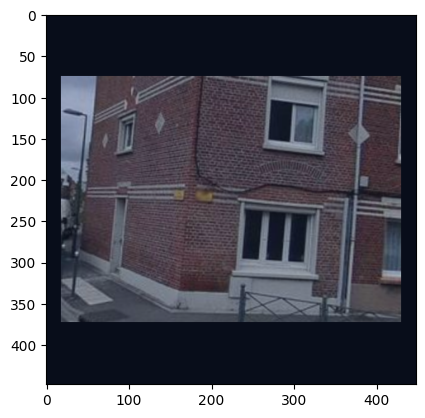

In [50]:
infer_model(img_torch,inference_dict['models'][1],"MSE")

In [13]:
(4 - 3.9173) /  1 

0.0827

# Compare model confidence about the result and Ensemble !!  

In [14]:
'''
gather predictions of CE model 

'''

model = inference_dict['models'][0]


from tqdm import tqdm 

batch_size = 8
TrainLoader = DataLoader(train_set,batch_size)
ValidLoader = DataLoader(valid_set,batch_size,shuffle=False)

device = "cuda:3"

#-- Loader train/valid
Loader = ValidLoader
#--
labels_ = []
predictions_ = []
for batch in tqdm(Loader):
    imgs = batch[0].to(device)
    lables = batch[1]
    batch_preds = model(imgs)
    #predictions = torch.argmax(batch_preds,-1)
    
    #-- 
    predictions_.extend(batch_preds.detach().cpu())
    labels_.extend(lables)

#---
inference_dict['predictions'].append(predictions_)
inference_dict['labels'].append(labels_)


100%|██████████| 386/386 [01:32<00:00,  4.18it/s]


In [18]:
inference_dict['predictions'][0].__len__()

3085

In [19]:
'''
gather predictions of MSE model 

'''

model = inference_dict['models'][1]

#--
labels_ = []
predictions_ = []
for batch in tqdm(Loader):
    imgs = batch[0].to(device)
    lables = batch[1]
    batch_preds = model(imgs)
    #predictions = torch.argmax(batch_preds,-1)
    
    #-- 
    predictions_.extend(batch_preds.detach().cpu())
    labels_.extend(lables)

#---
inference_dict['predictions'].append(predictions_)
inference_dict['labels'].append(labels_)



100%|██████████| 386/386 [01:31<00:00,  4.23it/s]


In [20]:
inference_dict['predictions'][1].__len__()

3085

In [44]:
ce_model_confidence_reverse = [1 - max(i.softmax(-1)) for i in inference_dict['predictions'][0]]

In [45]:
regression_model_confidence_reverse = [abs(np.round(i) - i)  for i in inference_dict['predictions'][1]]

In [53]:
idxs_ce_more_confidence = []
cnt = 0
for i, (ce,re) in enumerate( zip(ce_model_confidence_reverse,regression_model_confidence_reverse) ):
    if ce < re:
        print(i)
        idxs_ce_more_confidence.append(i)
        cnt += 1

print(f"# of cases ce model more confident : {cnt} / {len(ce_model_confidence_reverse)}")

0
1
2
5
6
8
9
10
11
12
14
16
17
18
19
20
22
23
25
26
27
28
30
31
33
35
36
39
41
42
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
62
63
65
66
67
68
69
70
71
73
74
75
76
77
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
101
103
104
105
106
107
109
110
111
112
114
116
118
120
122
124
125
128
129
130
131
132
133
134
135
138
139
140
141
143
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
164
165
166
167
168
169
171
172
173
174
175
176
177
179
180
181
182
183
184
185
186
190
191
192
193
194
196
197
198
199
201
202
203
205
207
208
209
210
212
214
215
216
217
218
219
220
222
224
225
226
227
231
232
233
234
235
236
237
238
239
241
245
246
248
249
250
251
252
253
254
255
259
261
262
263
264
265
266
268
270
271
272
273
274
275
279
281
282
284
285
286
287
288
289
290
291
293
294
295
296
297
298
301
302
303
304
305
306
307
309
311
312
313
315
316
317
318
319
320
321
322
323
324
325
327
330
331
333
334
335
336
337
338
339
340
341
342
343
345
346
348
349
350
351
352
353
355

In [62]:
0 in idxs_ce_more_confidence

True

In [74]:
ensemble_predictions = []

for idx in range(len(ce_model_confidence_reverse)):
    
    ce_pred = inference_dict['predictions'][0][idx].softmax(-1).argmax(-1)
    rg_pred = inference_dict['predictions'][1][idx].round()
    
    if idx in idxs_ce_more_confidence:
        ensemble_predictions.append(ce_pred)
    else:
        ensemble_predictions.extend(rg_pred)

In [75]:
ensemble_predictions

[tensor(5),
 tensor(2),
 tensor(5),
 tensor(1.),
 tensor(1.),
 tensor(0),
 tensor(0),
 tensor(4.),
 tensor(4),
 tensor(0),
 tensor(6),
 tensor(4),
 tensor(5),
 tensor(2.),
 tensor(2),
 tensor(5.),
 tensor(6),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(5.),
 tensor(6),
 tensor(5),
 tensor(5.),
 tensor(0),
 tensor(2),
 tensor(4),
 tensor(5),
 tensor(5.),
 tensor(4),
 tensor(1),
 tensor(1.),
 tensor(0),
 tensor(1.),
 tensor(6),
 tensor(0),
 tensor(2.),
 tensor(0.),
 tensor(1),
 tensor(4.),
 tensor(2),
 tensor(0),
 tensor(2.),
 tensor(6),
 tensor(1),
 tensor(2),
 tensor(5),
 tensor(4),
 tensor(0),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(4),
 tensor(3),
 tensor(5),
 tensor(6),
 tensor(1),
 tensor(3),
 tensor(2.),
 tensor(2.),
 tensor(5.),
 tensor(4),
 tensor(5),
 tensor(3.),
 tensor(6),
 tensor(6),
 tensor(3),
 tensor(3),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(2.),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(3.),
 tensor(1),
 tensor(0),
 tensor(

In [76]:
inference_dict['labels'][0]

[tensor(5),
 tensor(2),
 tensor(5),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(6),
 tensor(3),
 tensor(5),
 tensor(2),
 tensor(1),
 tensor(5),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(1),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(2),
 tensor(4),
 tensor(6),
 tensor(5),
 tensor(4),
 tensor(1),
 tensor(1),
 tensor(0),
 tensor(1),
 tensor(5),
 tensor(0),
 tensor(2),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(3),
 tensor(0),
 tensor(1),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(2),
 tensor(3),
 tensor(0),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(4),
 tensor(3),
 tensor(5),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(2),
 tensor(1),
 tensor(5),
 tensor(4),
 tensor(5),
 tensor(1),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(3),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(6),
 tensor(4),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(5),
 ten

In [82]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(labels_, ensemble_predictions, average='weighted')
accuracy = accuracy_score(labels_, ensemble_predictions)

print("Ensemble Result : ")
print(precision, recall, f1, _,accuracy) 

Ensemble Result : 
0.6711290006511128 0.6654781199351701 0.6672236479863993 None 0.6654781199351701


In [81]:
ce_predictions = [ inference_dict['predictions'][0][idx].softmax(-1).argmax(-1) for idx in range(len(ensemble_predictions)) ] 

In [90]:
precision, recall, f1, _ = precision_recall_fscore_support(labels_, ce_predictions, average='weighted')
accuracy = accuracy_score(labels_, ce_predictions)

print("CE Result : ")
print(precision, recall, f1, _,accuracy) 

CE Result : 
0.6628736739059818 0.6609400324149108 0.6603726753711758 None 0.6609400324149108


In [88]:
rg_predictions = [ inference_dict['predictions'][1][idx].round()[0] for idx in range(len(ensemble_predictions)) ] 

In [92]:
precision, recall, f1, _ = precision_recall_fscore_support(labels_, rg_predictions, average='weighted')
accuracy = accuracy_score(labels_, rg_predictions)

print("Regression Result : ")
print(precision, recall, f1, _,accuracy) 

Regression Result : 
0.625191844284788 0.6029173419773096 0.609829273232553 None 0.6029173419773096
